In [2]:

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pandas  # used to load metadata table
import numpy as np
import sys
import lmfit as lmfit
import glob as glob



import numpy as np
import os
from Xana import Xana
from Xana.misc.makemask import masker
from matplotlib.colors import LogNorm


import pandas as pd
import pickle
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
from matplotlib import rc
import h5py
import os

from scipy import interpolate
import scipy.integrate as integrate

import matplotlib.pyplot as plt
import midtools



Functions and variables for contrast

In [3]:
# variables
bs         = 15*1e-6    # beam size in m 
d         =  1.5e-3   # sample thickness in m
E         =  9        # Energy in keV
L         =  7   # sample-detector-distance in m
delLamLam =  5e-3     # Delta E over E: pink: 2e-3, in felix paper it is fixed at 5e-3 for some reason
P         =  200e-6    # pixel size in m



def calculate_M_det(E,q,delLamLam,bs,L,P,d):

    theta = calculate_theta(q,E)
    M_rad = calculate_M_rad(q,delLamLam,bs,E)
    M_det = np.sqrt(1+P**4*bs**2/(M_rad**2*(wavelength(E)* L)**4 )*( (bs**2)*np.cos(theta/2)**2+ (d**2)*np.sin(theta/2)**2) )

    return M_det


def calculate_M_rad(q,delLamLam,bs,E):
    theta=calculate_theta(q,E)
    M_rad=np.sqrt(1+(q**2)*(delLamLam**2)/(4*(np.pi)**2)*((bs**2)*(np.cos(theta))**2 + (d**2)*(np.sin(theta))**2 ))
    return M_rad


def speckle_contrast(E,q,delLamLam,bs,L,P,d):
    q=q*1e9
    beta = .5/(calculate_M_rad(q,delLamLam,bs,E)*calculate_M_det(E,q,delLamLam,bs,L,P,d))
    return beta

def wavelength(E):
    lam = 1.24/E*1e-9
    return lam


def calculate_theta(q,E):
    theta=np.arcsin(q/(4*np.pi/wavelength(E)))*2
    return theta



Functions for g2 definition and fitting

In [6]:
def calculate_g2(ttc):
    """Calculate the g2 function from a TTC
    """
    g2 = []
    dg2 = []
    ttc[ttc<.85]=np.nan
    
    for i in range(1,ttc.shape[0]):
        g2.append(np.nanmean(np.diag(ttc, k=i)))
        dg2.append(np.nanstd(np.diag(ttc, k=i))/np.sqrt(len(np.diag(ttc, k=i))))
    return g2,dg2

def calculate_g2_weighted(ttc,err_ttc):
    """Calculate the g2 function from a TTC using errorbars on the ttcs
    """
    g2 = []
    dg2 = []
    ttc[ttc<.85]=np.nan
    w=1/(err_ttc**2)
    for i in range(1,ttc.shape[0]):
        g2.append(np.nansum(np.diag(ttc, k=i)*np.diag(w, k=i))/np.nansum(np.diag(w, k=i)))
        dg2.append(1/np.nansum(np.diag(w, k=i)))
    return g2,dg2

    
    
def exp_fun(x, A, tau,beta,inter):
    res = A * np.exp(-2*(x / tau) ** beta)+inter
    return res



def exp_qdep(x,kww,A,baseline,tau1,tau2,tau3,tau4,tau5,tau6,tau7,tau8,tau9,tau10,tau11,tau12,tau13,tau14,tau15):

    tau=np.array([tau1,tau2,tau3,tau4,tau5,tau6,tau7,tau8,tau9,tau10,tau11,tau12,tau13,tau14,tau15])
    
    t=x[:,0]
    qvalues=x[:,1]
    contrast=speckle_contrast(E,qvalues,delLamLam,bs,L,P,d)
    tau_new=np.repeat(tau,len(t)/15)
    result=A*contrast*np.exp(-(t/(tau_new))**kww_function(kww,qvalues))+baseline
    
    
    return(result)


def kww_function(kww,q):
    kww_new=(1-kww*q)

    return(kww_new)

In [5]:
pathtodata='/gpfs/exfel/u/scratch/MID/202202/p003094/Anita/analyzed_runs_photonised_ADU8p9/p003094/'

Filters for position and energy

In [8]:
namefile='c_120_abs4_RT_errorbars'
t_delay=.44

data=np.load(f'{pathtodata}{namefile}.npz')
ttcs=data['ttcs']
err_ttcs=data['err_ttcs']

qvalues=data['q']

bin_centers_std=data['bin_centers_std'][:]
n_std_all=data['n_std_all'][:]
high_std_threshold_all=data['high_std_threshold_all'][:],

bin_centers_mean=data['bin_centers_mean'][:],
n_mean_all=data['n_mean_all'][:],
minttcmean=data['minttcmean'],
maxttcmean=data['maxttcmean'],

bin_centers_energy=data['bin_centers_energy'][:],
n_energy=data['n_energy'][:],
min_energy=data['min_energy'],
max_energy=data['max_energy'],

maxpositionz=data['maxpositionz'],
minpositionz=data['minpositionz'],

maxposition=data['maxposition'],
minposition=data['minposition'],

position_filter=data['position_filter'],

n_tot_files=data['n_tot_files']

print(r'data loaded')


data loaded


[0.21666667 0.25       0.28333333 0.31666667 0.35       0.38333333
 0.41666667 0.45       0.48333333 0.51666667 0.55       0.58333333
 0.61666667 0.65       0.68333333]
q=0
q=1
q=2
q=3
q=4
q=5
q=6
q=7
q=8
q=9
q=10
q=11
q=12
q=13
q=14


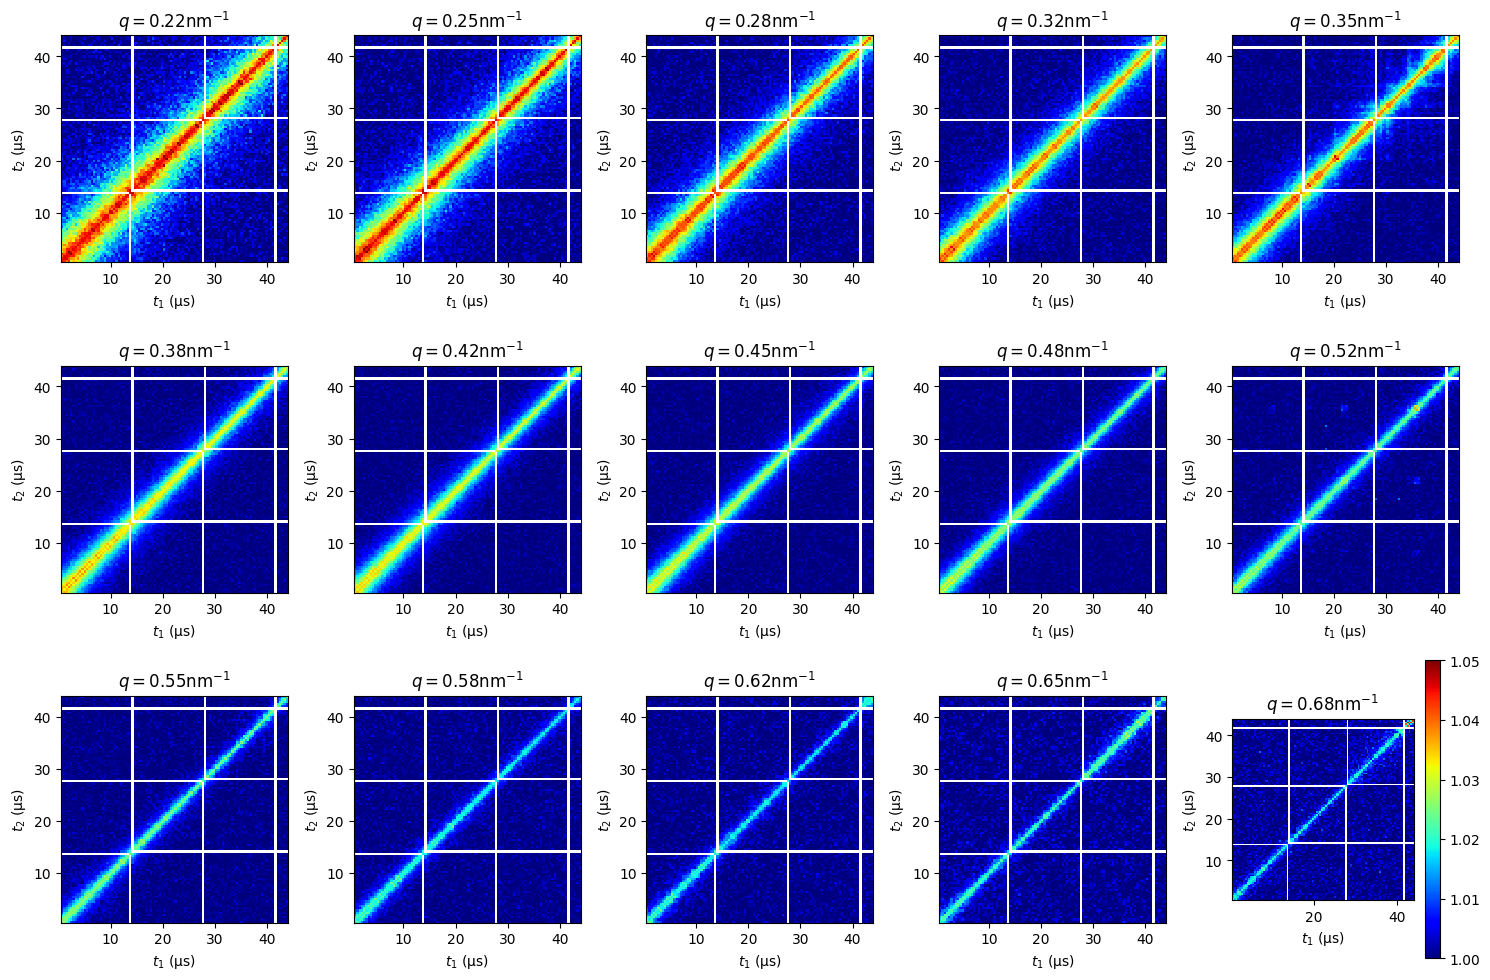

In [7]:
print(qvalues)
qnum=len(qvalues)

qmin=0
qmax=qnum

colore=plt.cm.jet(np.linspace(0,1,qmax-qmin))

tot_frames=100


fig=plt.figure(figsize=(15,10))

for i,q in enumerate(range(qmin,qmax)):
    print(f'q={q}')
        
    plt.figure(fig)
    plt.subplot(3,5,q-qmin+1)

    plt.imshow(ttcs[q,:,:],origin='lower',cmap='jet',vmin=1,vmax=1.05,extent=(t_delay,t_delay*tot_frames,t_delay,t_delay*tot_frames,),interpolation='none')
    plt.title('$q=$'+str(np.round(qvalues[q],2))+'nm$^{-1}$')
    
    if q==qmax-1:
        plt.colorbar()
    plt.tight_layout()
    plt.ylabel('$t_2$ (μs)')
    plt.xlabel('$t_1$ (μs)')
    


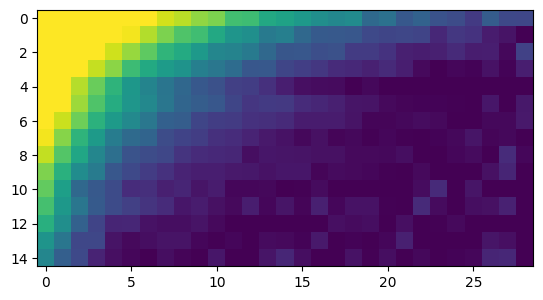

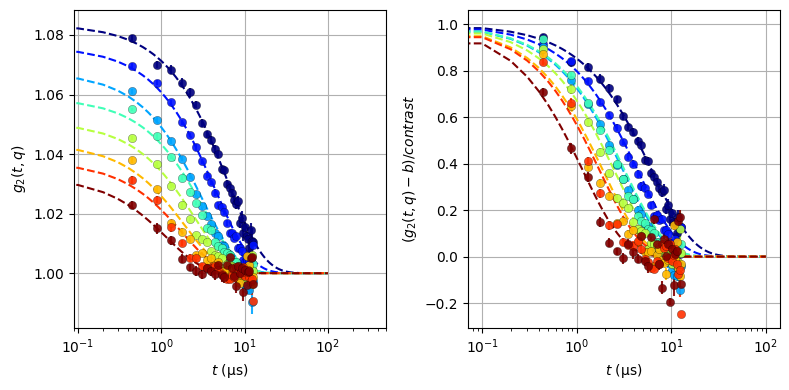

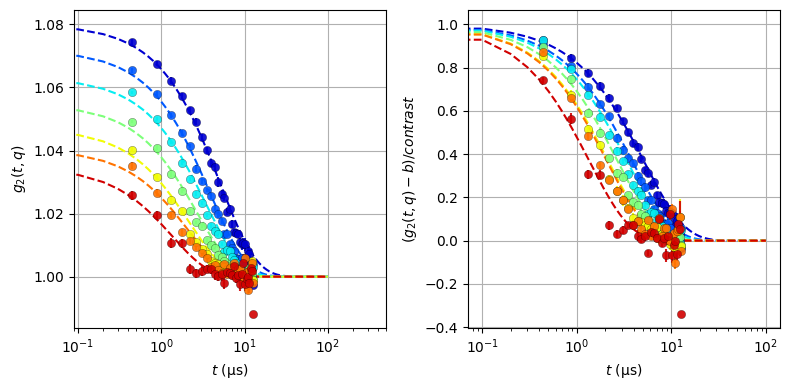

In [47]:
qmax=15


contrast=speckle_contrast(E,qvalues,delLamLam,bs,L,P,d)
colore=plt.cm.jet(np.linspace(0,1,qmax-qmin))
A, beta, inter = (0 for i in range(3))
dA, dbeta, dinter = (0 for i in range(3))
tau,dtau=(np.zeros([qmax-qmin]) for i in range(2))
deltac=0.001



tminframes=0
tmaxframes=30

allg2=[]
alldg2=[]
t_new=np.arange(1000)*.1
t=np.arange(1,tmaxframes-tminframes)*t_delay

for q in range(qmin,qmax):
    g2,dg2=calculate_ttcs (ttcs[q,tminframes:tmaxframes,tminframes:tmaxframes])
 
    allg2.append(g2)
    alldg2.append(dg2)


plt.figure()
plt.imshow(allg2,vmin=1, vmax=1.05)


y=np.array(allg2[qmin:qmax]).flatten()
qgrid=np.repeat(qvalues[qmin:qmax],len(t))
times=np.array([t]*len(qvalues[qmin:qmax])).flatten()


x=np.zeros([len(qgrid),2])
x[:,0]=times
x[:,1]=qgrid

param_lowerboundary = list(np.array([  -.003,         0.999,       .9999   ]  +list(0*qvalues[qmin:qmax])    ).flatten())
param_upperboundary = list(np.array([   .003,        1.001 ,      1.0001  ]  +list(0*qvalues[qmin:qmax]+400)).flatten())
param_initialguess  = list(np.array([   0,        1,      1.]  +list(1/(qvalues[qmin:qmax]**2*2))  ).flatten())


popt, pcov = curve_fit(exp_qdep, xdata=x, ydata=y, sigma=x[:,0]**.8,
                   bounds=(param_lowerboundary,
                            param_upperboundary),
                        p0=param_initialguess )


kww= popt[0]
dkww = np.sqrt(np.diag(pcov))[0]

A = popt[1]
dA = np.sqrt(np.diag(pcov))[1]


baseline= popt[2]
dbaseline = np.sqrt(np.diag(pcov))[2]

for n,i in enumerate(range(3,len(popt))):
    tau[n]= popt[i]
    dtau[n] = np.sqrt(np.diag(pcov))[i]


plt.figure(figsize=(8,4))
for i,q in enumerate(range(qmin,qmax,2)):

    x_new=t_new

    y_new=A*contrast[q]*np.exp(-(t_new/(tau[q]))**kww_function(kww,qvalues[q]))+baseline
    

    plt.subplot(1,2,1)
    plt.errorbar(t,(allg2[q]) ,alldg2[q],marker='o',ls=' ',color=colore[q-qmin],
        label='$q$='+str(np.round(qvalues[q],2))+'nm$^{-1}$',markeredgewidth=.2,markeredgecolor='black',markersize=6,alpha=.9,)
        
    plt.plot(x_new,y_new,color=colore[q-qmin],linestyle='dashed')
    
    
    plt.subplot(1,2,2)

    plt.errorbar(t,(allg2[q]-baseline)/(contrast[q]*A) ,alldg2[i]/(contrast[q]*A),marker='o',ls=' ',markersize=6,alpha=.9,
        color=colore[q-qmin],label='$q$='+str(np.round(qvalues[q],2))+'nm$^{-1}$',markeredgewidth=.2,markeredgecolor='black')

    plt.plot(x_new, (y_new-baseline)/(contrast[q]*A), linestyle='dashed',color=colore[q-qmin])
    
plt.xscale('log')
plt.grid('on')

plt.xlabel('$t$ (μs)')
plt.ylabel('$(g_2(t,q)-b)/contrast$')
plt.tight_layout()

plt.subplot(1,2,1)
#plt.legend(loc='upper right')
plt.xscale('log')
plt.xlim([.09, 500])
plt.grid('on')

plt.xlabel('$t$ (μs)')
plt.ylabel('$g_2 (t,q)$')
plt.tight_layout()


plt.figure(figsize=(8,4))
for i,q in enumerate(range(qmin+1,qmax,2)):

    x_new=t_new

    y_new=A*contrast[q]*np.exp(-(t_new/(tau[q]))**kww_function(kww,qvalues[q]))+baseline
    

    plt.subplot(1,2,1)
    plt.errorbar(t,(allg2[q]) ,alldg2[q],marker='o',ls=' ',color=colore[q-qmin],
        label='$q$='+str(np.round(qvalues[q],2))+'nm$^{-1}$',markeredgewidth=.2,markeredgecolor='black',markersize=6,alpha=.9,)
        
    plt.plot(x_new,y_new,color=colore[q-qmin],linestyle='dashed')
    
    
    plt.subplot(1,2,2)

    plt.errorbar(t,(allg2[q]-baseline)/(contrast[q]*A) ,alldg2[i]/(contrast[q]*A),marker='o',ls=' ',markersize=6,alpha=.9,
        color=colore[q-qmin],label='$q$='+str(np.round(qvalues[q],2))+'nm$^{-1}$',markeredgewidth=.2,markeredgecolor='black')

    plt.plot(x_new, (y_new-baseline)/(contrast[q]*A), linestyle='dashed',color=colore[q-qmin])
    
plt.xscale('log')
plt.grid('on')

plt.xlabel('$t$ (μs)')
plt.ylabel('$(g_2(t,q)-b)/contrast$')
plt.tight_layout()

plt.subplot(1,2,1)
#plt.legend(loc='upper right')
plt.xscale('log')
plt.xlim([.09, 500])
plt.grid('on')

plt.xlabel('$t$ (μs)')
plt.ylabel('$g_2 (t,q)$')
plt.tight_layout()


kww
-0.002999999999999986
[1.00035 1.00045 1.00055 1.00065 1.00075 1.00085 1.00095 1.00105 1.00115
 1.00125 1.00135 1.00145 1.00155 1.00165 1.00175]
A
1.0009999999999997
baseline
1.0000999999999998


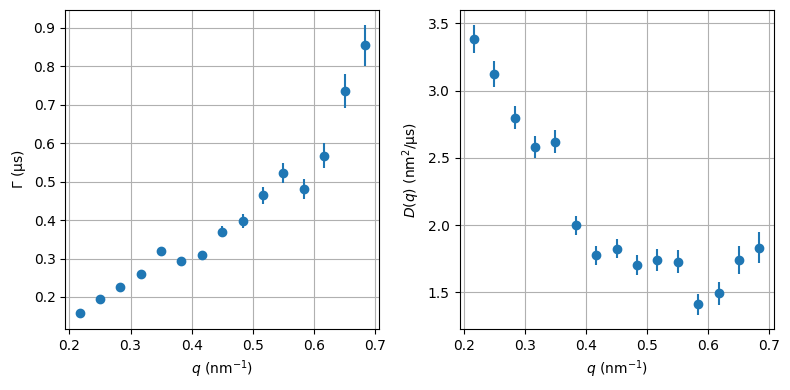

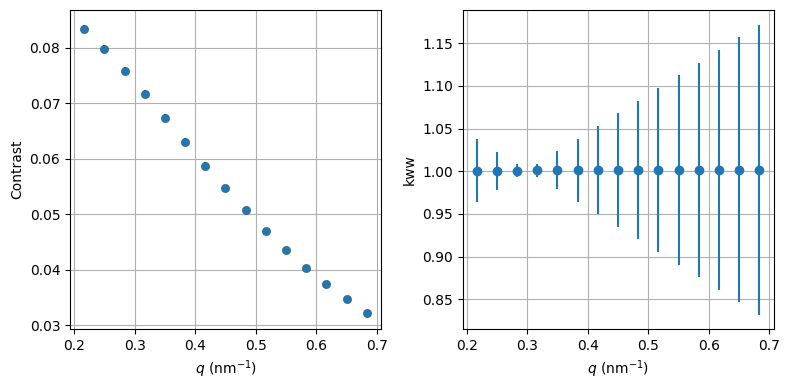

In [48]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.errorbar(qvalues[qmin:qmax],1/tau,1/tau**2*dtau,marker='o',ls='')
plt.xlabel('$q$ (nm$^{-1}$)')

plt.ylabel('$\Gamma$ (μs)')
#plt.ylim([0,.4])
plt.tight_layout()

plt.grid('on')

plt.subplot(1,2,2)

plt.errorbar(qvalues[qmin:qmax],1/tau/qvalues[qmin:qmax]**2,1/tau**2*dtau/qvalues[qmin:qmax]**2,marker='o',ls='')
plt.xlabel('$q$ (nm$^{-1}$)')

plt.ylabel('$D(q)$ (nm$^2$/μs)')
#plt.ylim([0,.4])

D_70=1/tau/qvalues[qmin:qmax]**2
dD_70=1/tau**2*dtau/qvalues[qmin:qmax]**2

plt.tight_layout()

plt.grid('on')


print('kww')
print(kww)
print(1-kww*(qvalues-.1))

print('A')
print(A)
print('baseline')
print(baseline)


plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.errorbar(qvalues[qmin:qmax],A*contrast,dA*contrast,marker='o',ls='',markeredgewidth=.2,markeredgecolor='black')
plt.xlabel('$q$ (nm$^{-1}$)')

plt.ylabel('Contrast')
#plt.ylim([0,.4])
plt.tight_layout()

plt.grid('on')

plt.subplot(1,2,2)

plt.errorbar(qvalues[qmin:qmax],kww_function(kww,qvalues[qmin:qmax]),np.abs(dkww*(qvalues-.3)*10),marker='o',ls='')
plt.xlabel('$q$ (nm$^{-1}$)')

plt.ylabel('kww')
#plt.ylim([0,.4])
plt.tight_layout()

plt.grid('on')




Text(0, 0.5, '$D_0/D(q)$')

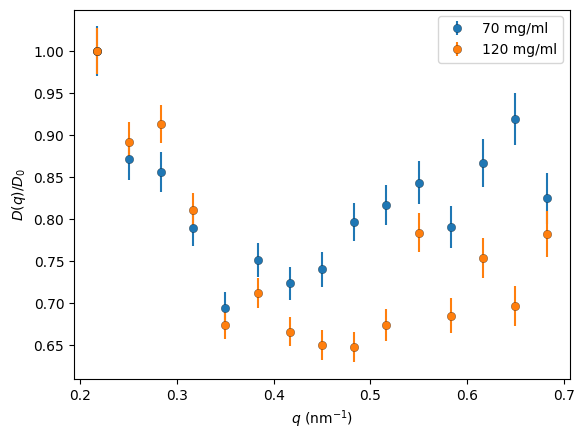

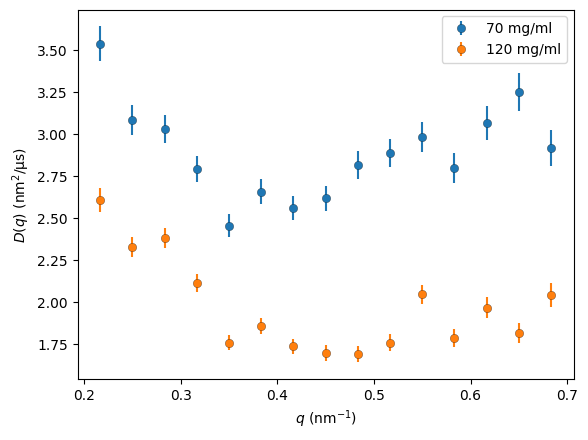

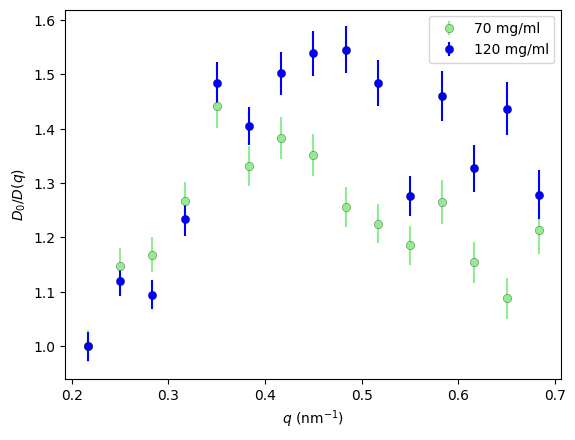

In [384]:
plt.figure()

plt.errorbar(qvalues,D_70/D_70[0],dD_70/D_70[0],marker='o',ls='',markeredgewidth=.2,markeredgecolor='black')
plt.errorbar(qvalues,D_120/D_120[0],dD_120/D_120[0],marker='o',ls='',markeredgewidth=.2,markeredgecolor='black')
plt.xlabel('$q$ (nm$^{-1}$)')
plt.legend(['70 mg/ml','120 mg/ml'])
plt.ylabel('$D(q)/D_0$')

plt.figure()

plt.errorbar(qvalues,D_70,dD_70,marker='o',ls='',markeredgewidth=.2,markeredgecolor='black')
plt.errorbar(qvalues,D_120,dD_120,marker='o',ls='',markeredgewidth=.2,markeredgecolor='black')
plt.xlabel('$q$ (nm$^{-1}$)')
plt.legend(['70 mg/ml','120 mg/ml'])
plt.ylabel('$D(q)$ (nm$^2$/μs)')


plt.figure()

plt.errorbar(qvalues,D_70[0]/D_70,D_70[0]/D_70**2*dD_70,marker='o',ls='',markeredgewidth=.2,markeredgecolor='black',color='lightgreen')
plt.errorbar(qvalues,D_120[0]/D_120,D_120[0]/D_120**2*dD_120,marker='o',ls='',markeredgewidth=.2,markeredgecolor='black',color='blue')
plt.xlabel('$q$ (nm$^{-1}$)')
plt.legend(['70 mg/ml','120 mg/ml'])
plt.ylabel('$D_0/D(q)$')



array([0.04940899, 0.04770259, 0.04584038, 0.04385915, 0.04179732,
       0.03969273, 0.03758054, 0.03549169, 0.03345194, 0.03148149,
       0.02959513, 0.02780277, 0.02611013, 0.0245195 , 0.02303053])

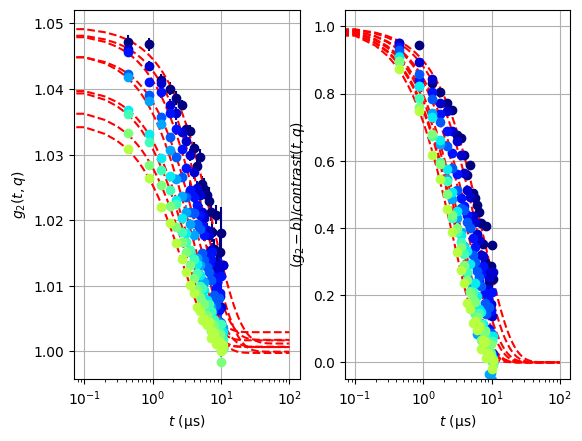

In [68]:
colore=plt.cm.jet(np.linspace(0,1,qmax-qmin))
tau, A, beta, inter = (np.zeros([qnum]) for i in range(4))
dtau, dA, dbeta, dinter = (np.zeros([qnum]) for i in range(4))

deltac=0.001
qmax=9
plt.figure()

contrast =speckle_contrast(E,qvalues,delLamLam,bs,L,P,d)/2.4

for i,q in enumerate(range(qmin,qmax)):
   
    
    popt, pcov = curve_fit(exp_fun, xdata=t, ydata=allg2[i],sigma=t**.5/100,
                           bounds=([contrast[q]-deltac,       0,       .9,   .995,],
                                   [contrast[q]+deltac,  10 ** 4,     1.1,   1.01,]),
                           p0    =([contrast[q],              .1,        1,   1.0001])  )
    A[q] = popt[0]
    dA[q] = np.sqrt(np.diag(pcov))[0]
    tau[q] = popt[1]
    dtau[q] = np.sqrt(np.diag(pcov))[1]
    beta[q] = popt[2]
    dbeta[q] = np.sqrt(np.diag(pcov))[2]
    inter[q] = popt[3]
    dinter[q] = np.sqrt(np.diag(pcov))[3]


    
    plt.subplot(1,2,1)
    plt.errorbar(t,(allg2[i]) ,alldg2[i],marker='o',ls=' ',color=colore[q-qmin],label='$q$='+str(np.round(qvalues[q],2))+'nm$^{-1}$')
    plt.plot(t_new, (exp_fun(t_new, popt[0], popt[1], popt[2], popt[3])), color='red',linestyle='dashed')
    plt.subplot(1,2,2)
    plt.errorbar(t,(allg2[i]-popt[3])/popt[0] ,alldg2[i],marker='o',ls=' ',color=colore[q-qmin],label='$q$='+str(np.round(qvalues[q],2))+'nm$^{-1}$')
    plt.plot(t_new, (exp_fun(t_new, popt[0], popt[1], popt[2], popt[3])-popt[3])/popt[0], color='red',linestyle='dashed')
    
plt.xscale('log')
plt.grid('on')
plt.ylim([-.05,1.05])
plt.xlabel('$t$ (μs)')
plt.ylabel('$(g_2-b)/contrast(t,q)$')

plt.subplot(1,2,1)
plt.xscale('log')
plt.grid('on')

plt.xlabel('$t$ (μs)')
plt.ylabel('$g_2 (t,q)$')
#plt.ylim([1.04,1.1])

contrast


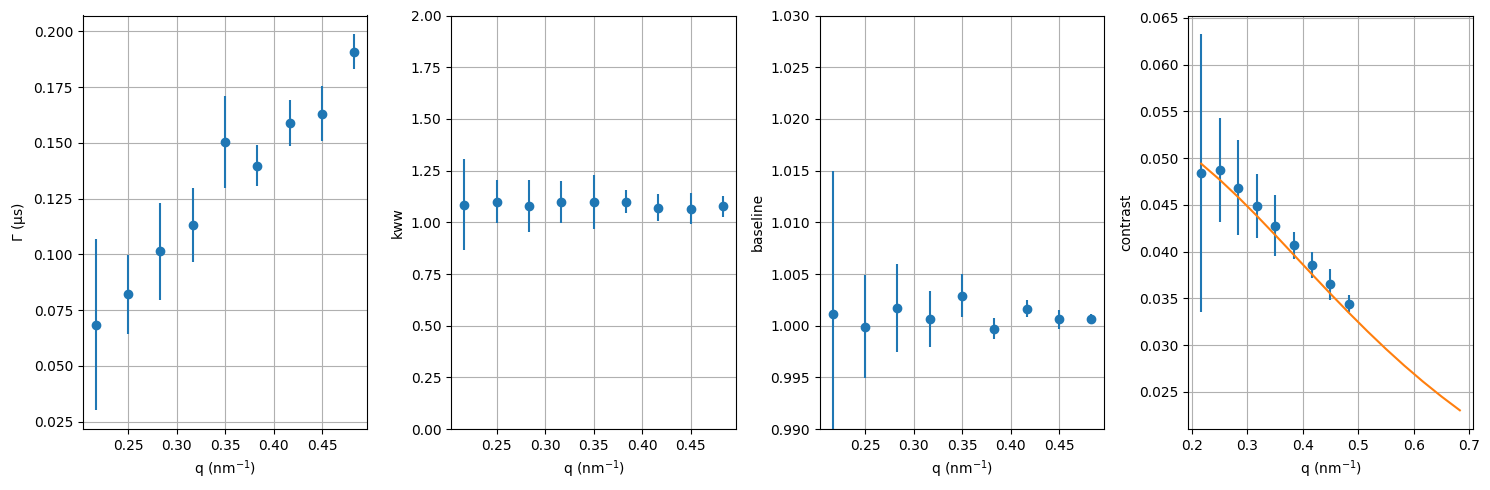

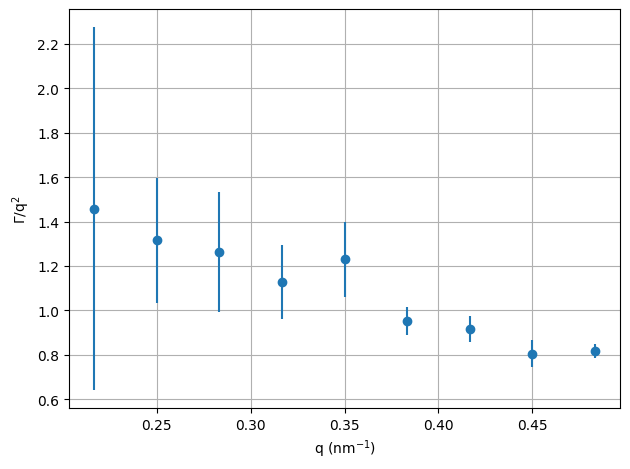

In [69]:
plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
plt.errorbar(qvalues[tau>0],1/tau[tau>0],1/tau[tau>0]**2*dtau[tau>0],marker='o',ls='')
plt.xlabel('q (nm$^{-1}$)')

plt.ylabel('$\Gamma$ (μs)')
#plt.ylim([0,.4])
plt.tight_layout()

plt.grid('on')

plt.subplot(1,4,2)
plt.errorbar(qvalues[tau>0],beta[tau>0],dbeta[tau>0],marker='o',ls='')
plt.xlabel('q (nm$^{-1}$)')

plt.ylabel('kww')
plt.ylim([0,2])
plt.tight_layout()
plt.grid('on')

plt.subplot(1,4,3)
plt.errorbar(qvalues[tau>0],inter[tau>0],dinter[tau>0],marker='o',ls='')
plt.xlabel('q (nm$^{-1}$)')

plt.ylabel('baseline')
plt.ylim([.99,1.03])
plt.tight_layout()
plt.grid('on')

plt.subplot(1,4,4)
plt.errorbar(qvalues[tau>0],A[tau>0],dA[tau>0],marker='o',ls='')
plt.plot(qvalues,contrast)
plt.xlabel('q (nm$^{-1}$)')
plt.ylabel('contrast')
#plt.ylim([0,.13])
plt.tight_layout()
plt.grid('on')



plt.figure()
plt.errorbar(qvalues[tau>0],1/tau[tau>0]/qvalues[tau>0]**2,1/tau[tau>0]**2*dtau[tau>0]/qvalues[tau>0]**2,marker='o',ls='')
plt.xlabel('q (nm$^{-1}$)')

plt.ylabel('$\Gamma$/q$^2$')
#plt.ylim([0,.4])
plt.tight_layout()

plt.grid('on')

Text(0.5, 0, '$t_1$ (μs)')

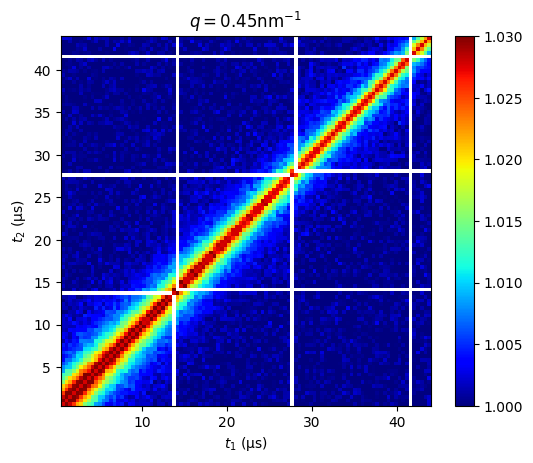

In [26]:

plt.figure()
plt.imshow(ave_ttc,vmin=1,vmax=1.03,origin='lower',cmap='jet',extent=(t_delay,t_delay*totframes,t_delay,t_delay*totframes,))
plt.title('$q=$'+str(np.round(qvalues[q],2))+'nm$^{-1}$')
plt.colorbar()

plt.ylabel('$t_2$ (μs)')
plt.xlabel('$t_1$ (μs)')

/tmp/ipykernel_16236/3365949347.py:8: RuntimeWarning: Mean of empty slice
  g2.append(np.nanmean(np.diag(ttc, k=i)))
/home/girellia/virtual_env/.venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0, 0.5, '$g_2 (t,t_w,q)$')

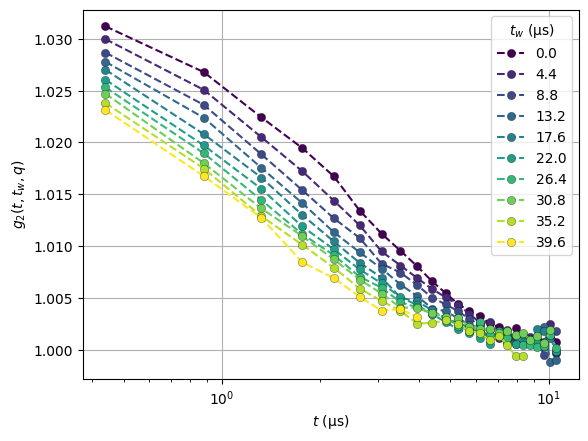

In [30]:


deltat=10
tmax=25
colore=plt.cm.viridis(np.linspace(0,1,int(100/deltat)))

plt.figure()
for i in range(int(100/deltat)):
    g2,dg2=calculate_g2(ave_ttc_baselinecorrected[i*deltat:i*deltat+tmax,i*deltat:i*deltat+tmax])
    plt.plot(t[1:len(g2)+1],g2,marker='o',ls='dashed',color=colore[i],label=str(np.round(t_delay*i*deltat,1)),markeredgewidth=.2,markeredgecolor='black')

plt.legend(title='$t_w$ (μs)')

plt.xscale('log')
plt.grid('on')

plt.xlabel('$t$ (μs)')
plt.ylabel('$g_2 (t,t_w,q)$')


Text(0, 0.5, '$D_{ave}$ (nm$^2$/μs)')

<Figure size 640x480 with 0 Axes>

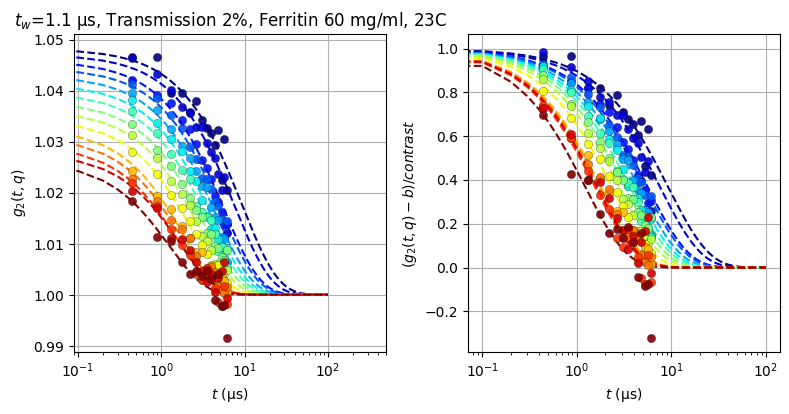

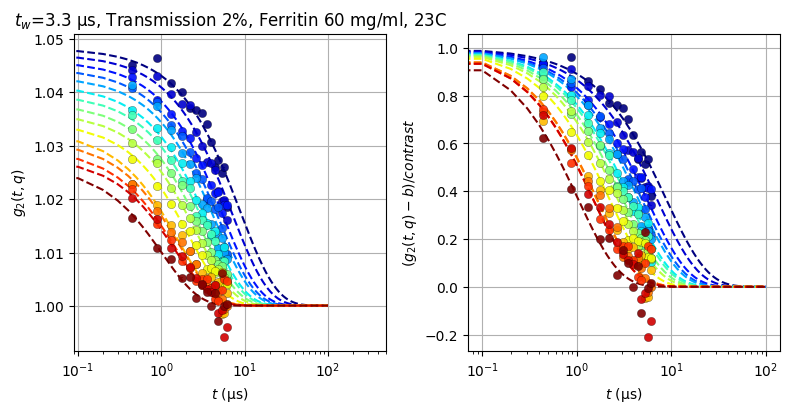

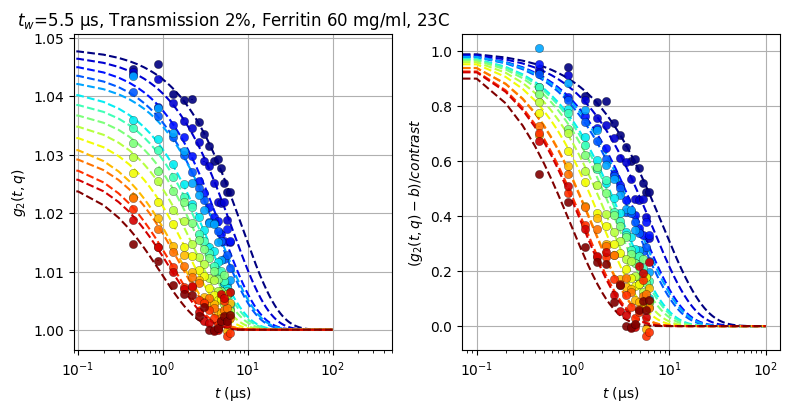

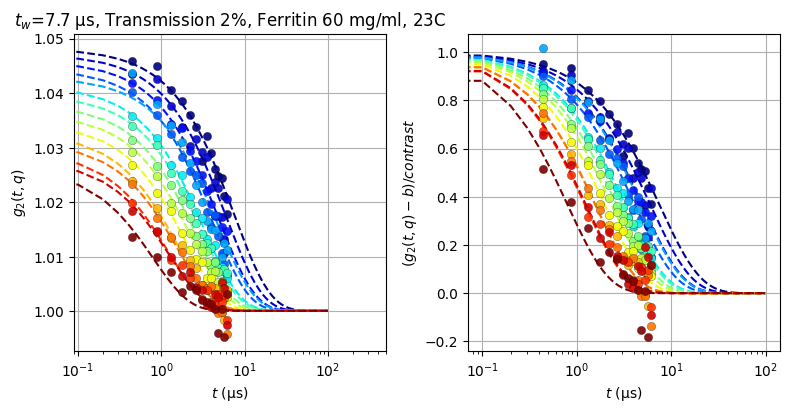

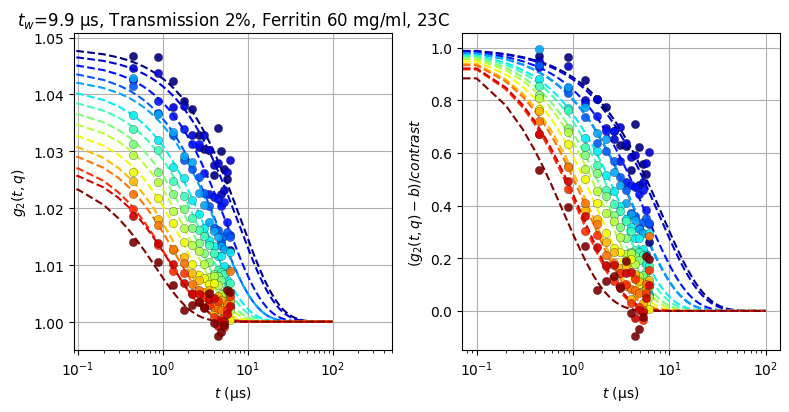

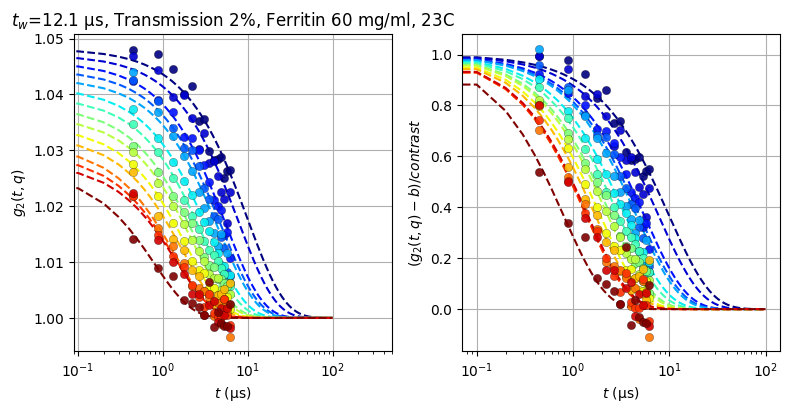

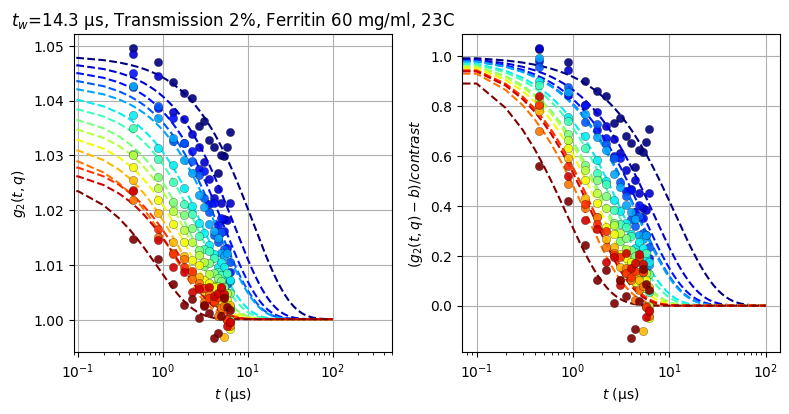

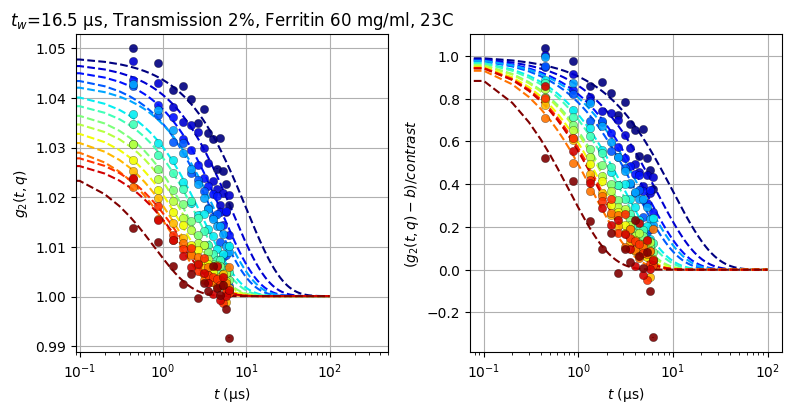

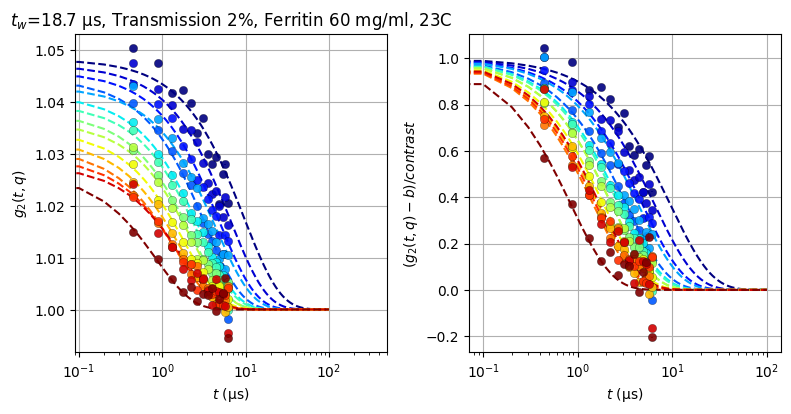

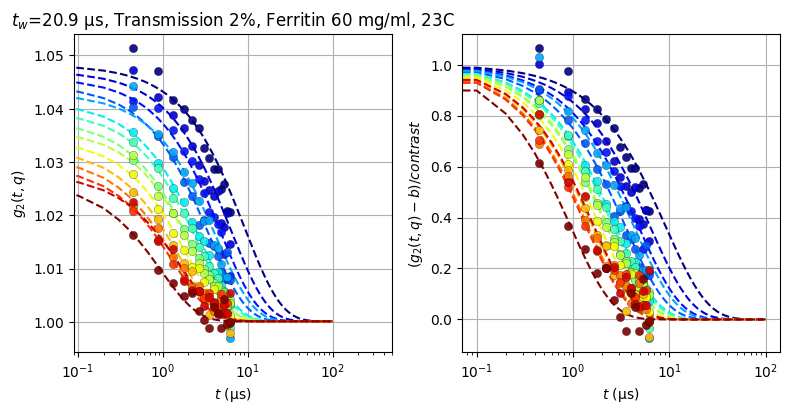

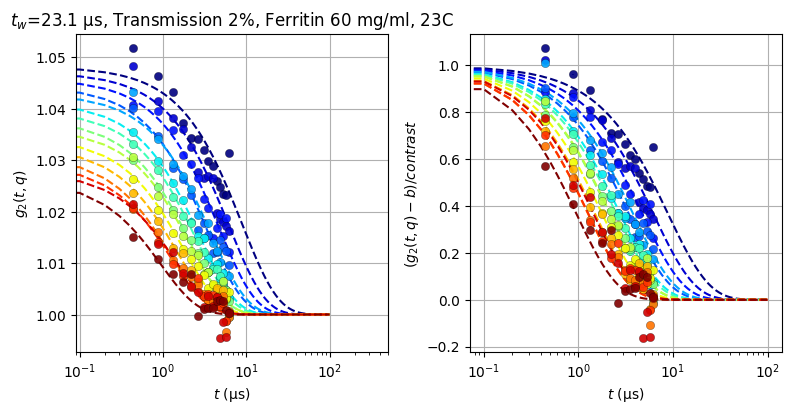

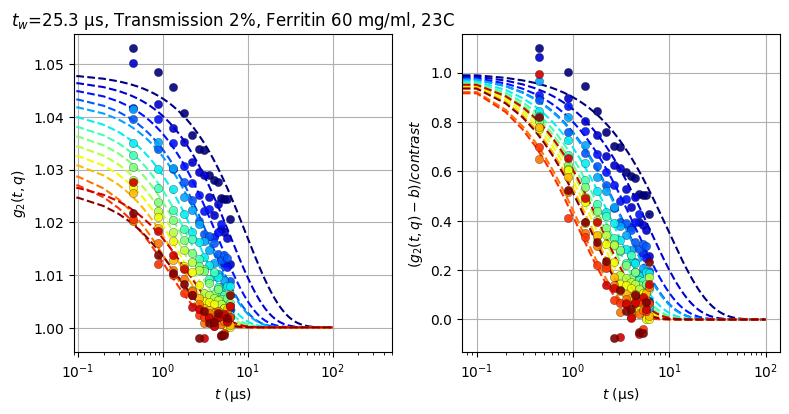

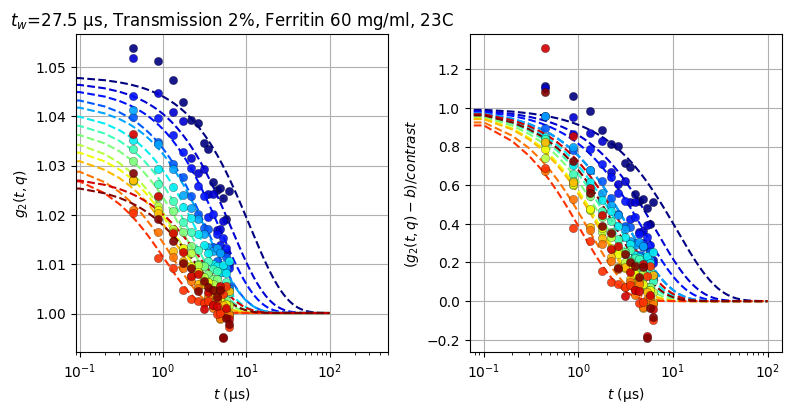

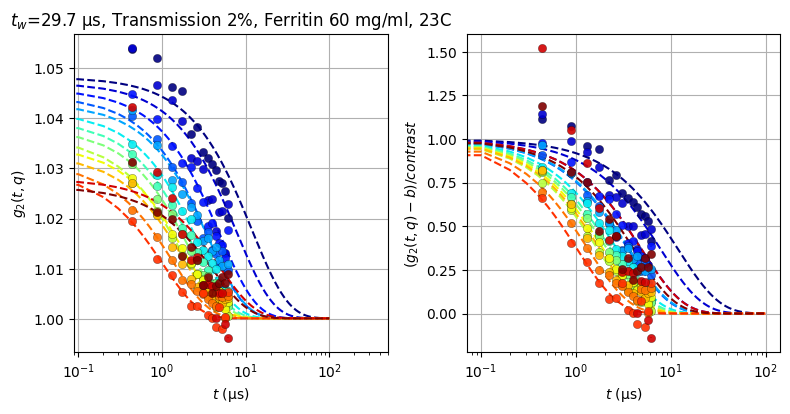

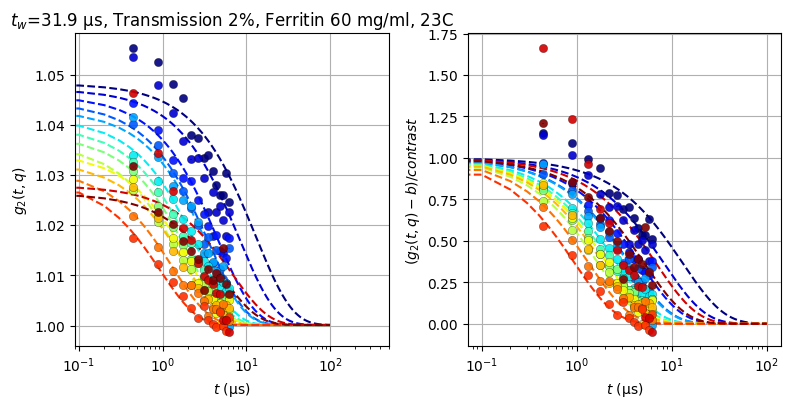

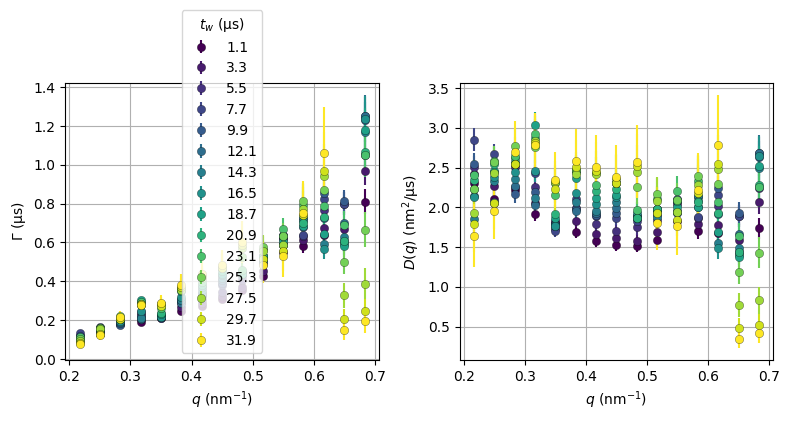

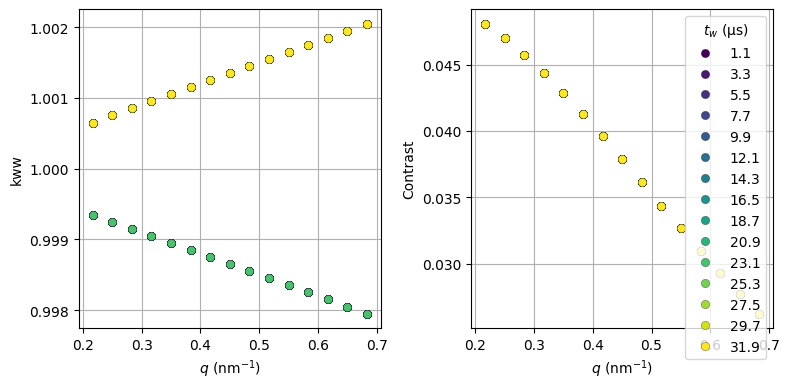

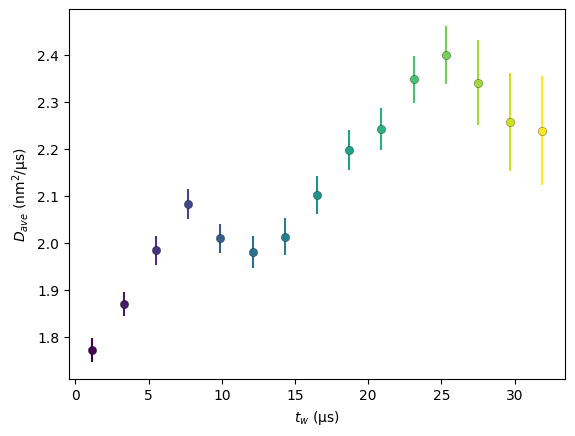

In [32]:

namefile='c_120_abs2_RT_errorbars'
t_delay=.44

deltat=5

tmax=15

n_time_slices=int(75/deltat)

qmin=0
qmax=15

colore=plt.cm.jet(np.linspace(0,1,qmax-qmin))
colore_time=plt.cm.viridis(np.linspace(0,1,n_time_slices))


t_w,A, kww, baseline,dA, dkww, dbaseline = (np.zeros([n_time_slices]) for i in range(7))

D,dD,tau,dtau=(np.zeros([n_time_slices,qmax-qmin]) for i in range(4))



#contrast def

contrast=speckle_contrast(E,qvalues,delLamLam,bs,L,P,d)

#fit boundaries
param_lowerboundary = list(np.array([  -.003, 0.999,  .9999 ]  +list(0*qvalues[qmin:qmax])).flatten())
param_upperboundary = list(np.array([   .003, 1.001,  1.0001]  +list(0*qvalues[qmin:qmax]+500)).flatten())
param_initialguess  = list(np.array([   0,        1,      1.]  +list(1/(2*qvalues[qmin:qmax]**2))  ).flatten())



plt.figure()

data=np.load(f'{pathtodata}{namefile}.npz')
ttcs=data['ttcs']
err_ttcs=data['err_ttcs']
qvalues=data['q']

for i in range(n_time_slices):
    tminframes=i*deltat
    tmaxframes=i*deltat+tmax
    t_new=np.arange(1000)*.1
    t=np.arange(1,tmaxframes-tminframes)*t_delay

    t_w[i]=np.round(t_delay*i*deltat+deltat*t_delay/2,1)
    qgrid=np.repeat(qvalues[qmin:qmax],len(t))
    times=np.array([t]*len(qvalues[qmin:qmax])).flatten()

    x=np.zeros([len(qgrid),2])
    x[:,0]=times
    x[:,1]=qgrid
    allg2=[]
    alldg2=[]
    for q in range(qmin,qmax):
        g2,dg2=calculate_g2_weighted(ttcs[q,i*deltat:i*deltat+tmax,i*deltat:i*deltat+tmax],err_ttcs[q,i*deltat:i*deltat+tmax,i*deltat:i*deltat+tmax])
        allg2.append(g2)
        alldg2.append(dg2)

    y=np.array(allg2[qmin:qmax]).flatten()
    popt, pcov = curve_fit(exp_qdep, xdata=x, ydata=y, sigma=x[:,0]**.6,
                    bounds=(param_lowerboundary,
                                param_upperboundary),
                            p0=param_initialguess )
    #save fit parameters
    kww[i]= popt[0]
    dkww[i] = np.sqrt(np.diag(pcov))[0]
    A[i] = popt[1]
    dA[i] = np.sqrt(np.diag(pcov))[1]
    baseline[i]= popt[2]
    dbaseline[i] = np.sqrt(np.diag(pcov))[2]

    for n,j in enumerate(range(3,len(popt))):
        tau[i,n]= popt[j]
        dtau[i,n] = np.sqrt(np.diag(pcov))[j]
        D[i,n]=1/tau[i,n]/qvalues[n]**2
        dD[i,n]=1/tau[i,n]**2*dtau[i,n]/qvalues[n]**2
        
    
    #plot fit
    for qshift in range (1):
        fig1=plt.figure(figsize=(8,4))
        for j,q in enumerate(range(qmin+qshift,qmax)):
            x_new=t_new
            y_new=contrast[q]*np.exp(-(t_new/(tau[i,q]))**kww_function(kww[i],qvalues[q]))+baseline[i]
            
            plt.subplot(1,2,1)
            plt.errorbar(t,(allg2[q]) ,alldg2[q],marker='o',ls=' ',color=colore[q-qmin],
                label='$q$='+str(np.round(qvalues[q],2))+'nm$^{-1}$',markeredgewidth=.2,markeredgecolor='black',markersize=6,alpha=.9,)
            plt.plot(x_new,y_new,color=colore[q-qmin],linestyle='dashed')
            
            plt.subplot(1,2,2)
            plt.errorbar(t,(allg2[q]-baseline[i])/(contrast[q]*A[i]) ,alldg2[q]/(contrast[q]*A[i]),marker='o',ls=' ',markersize=6,alpha=.9,
                color=colore[q-qmin],label='$q$='+str(np.round(qvalues[q],2))+'nm$^{-1}$',markeredgewidth=.2,markeredgecolor='black')
            plt.plot(x_new, (y_new-baseline[i])/(contrast[q]*A[i]), linestyle='dashed',color=colore[q-qmin])
                
        plt.xscale('log')
        plt.grid('on')
        
        plt.xlabel('$t$ (μs)')
        plt.ylabel('$(g_2(t,q)-b)/contrast$')
        plt.tight_layout()

        plt.subplot(1,2,1)
        #plt.legend(loc='upper right')
        plt.xscale('log')
        plt.xlim([.09, 500])
        plt.grid('on')
        plt.xlabel('$t$ (μs)')
        plt.ylabel('$g_2 (t,q)$')
        plt.tight_layout()
        plt.figure(fig1)
        plt.title(f'$t_w$={t_w[i]} μs, Transmission 2%, Ferritin 60 mg/ml, 23C')
        

plt.figure(figsize=(8,4))
for i in range(n_time_slices):
    plt.subplot(1,2,1)
    plt.errorbar(qvalues[qmin:qmax],1/tau[i,:],1/tau[i,:]**2*dtau[i,:],marker='o',ls='',
    color=colore_time[i],markeredgewidth=.2,markeredgecolor='black')
    plt.xlabel('$q$ (nm$^{-1}$)')

    plt.legend(t_w,title='$t_w$ (μs)')
    plt.ylabel('$\Gamma$ (μs)')
    #plt.ylim([0,.4])
    plt.tight_layout()

    plt.grid('on')

    plt.subplot(1,2,2)
    plt.errorbar(qvalues[qmin:qmax],1/tau[i,:]/qvalues[qmin:qmax]**2,1/tau[i,:]**2*dtau[i,:]/qvalues[qmin:qmax]**2,
    marker='o',ls='',color=colore_time[i],markeredgewidth=.2,markeredgecolor='black')
    plt.grid('on')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.ylabel('$D(q)$ (nm$^2$/μs)')

plt.figure(figsize=(8,4))
for i in range(n_time_slices):
    plt.subplot(1,2,1)
    plt.plot(qvalues[qmin:qmax],kww_function(kww[i],qvalues[qmin:qmax]),marker='o',ls='',
    color=colore_time[i],markeredgewidth=.2,markeredgecolor='black')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.ylabel('kww')
    #plt.ylim([0,.4])
    plt.tight_layout()

    plt.grid('on')

    plt.subplot(1,2,2)
    plt.errorbar(qvalues[qmin:qmax],contrast,
    marker='o',ls='',color=colore_time[i],markeredgewidth=.2,markeredgecolor='black')
    plt.grid('on')
    plt.xlabel('$q$ (nm$^{-1}$)')
    plt.legend(t_w,title='$t_w$ (μs)')
    plt.ylabel('Contrast')




plt.figure()
for i in range(n_time_slices):
    meanD=np.sum(D[i,:11]*dD[i,:11]**-2)/np.sum(dD[i,:11]**-2)
    dmeanD=np.sqrt(1/np.sum(dD[i,:11]**-2))
    plt.errorbar(t_w[i],meanD,dmeanD,marker='o',ls='',color=colore_time[i],markeredgewidth=.2,markeredgecolor='black')
plt.xlabel('$t_w$ (μs)')
plt.ylabel('$D_{ave}$ (nm$^2$/μs)')


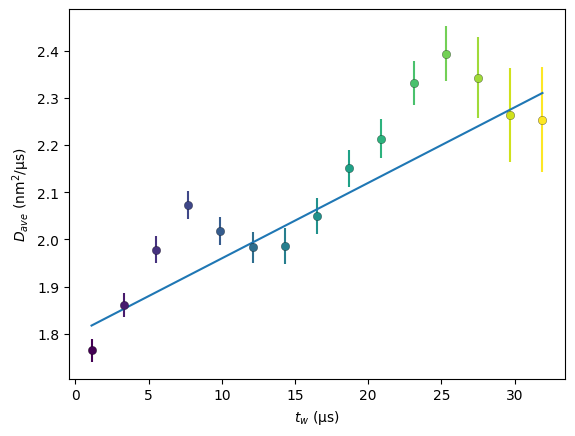

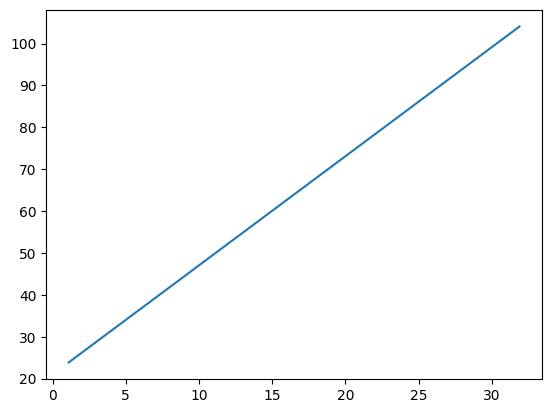

In [40]:

plt.figure()
for i in range(n_time_slices):
    meanD=np.sum(D[i,:13]*dD[i,:13]**-2)/np.sum(dD[i,:13]**-2)
    dmeanD=np.sqrt(1/np.sum(dD[i,:13]**-2))
    plt.errorbar(t_w[i],meanD,dmeanD,marker='o',ls='',color=colore_time[i],markeredgewidth=.2,markeredgecolor='black')
plt.plot(t_w,1.8+t_w*.016)
plt.xlabel('$t_w$ (μs)')
plt.ylabel('$D_{ave}$ (nm$^2$/μs)')



plt.figure()
plt.plot(t_w,21+t_w*.016/1.8*293)

Text(0, 0.5, '$D_{ave}$ (nm$^2$/μs)')

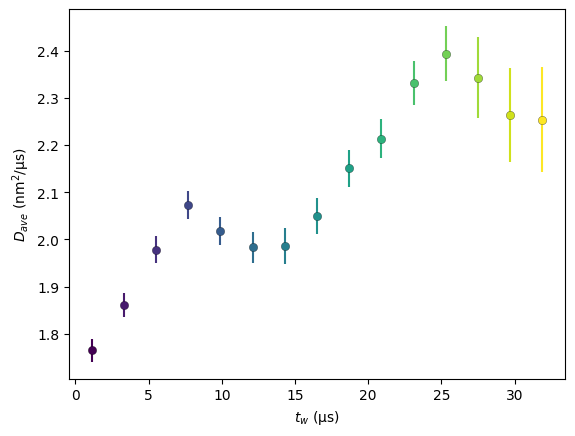

In [25]:

plt.figure()
for i in range(n_time_slices):
    meanD=np.sum(D[i,:13]*dD[i,:13]**-2)/np.sum(dD[i,:13]**-2)
    dmeanD=np.sqrt(1/np.sum(dD[i,:13]**-2))
    plt.errorbar(t_w[i],meanD,dmeanD,marker='o',ls='',color=colore_time[i],markeredgewidth=.2,markeredgecolor='black')
plt.xlabel('$t_w$ (μs)')
plt.ylabel('$D_{ave}$ (nm$^2$/μs)')